In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np 
from time import perf_counter #measuring time of CNN training

### Setting some hyperparameters and device

In [156]:
#setting the devide configurations in case you have GPU
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')

#hyperparameters
n_epochs=14 #recall that you'll have n_tot_steps= 50,000(CIFAR DATA)/batch_size)= 50k/B 
batch_size=64
l_rate=5e-4

Overall results are likely to have an accuracy of $\approx 64 \%$ you can set a seed in order to reproduce a exact result
you can use the following cell to reproduce 

In [160]:
# import random
#SEED = 42
# def seed_worker(worker_id):  #for reproducibility use the comment lines
#     worker_seed = torch.initial_seed() % 2**32
#     np.random.seed(worker_seed); random.seed(worker_seed)

# g = torch.Generator(); g.manual_seed(SEED)

# train_loader = DataLoader(trainset, shuffle=True, num_workers=2,
#                           worker_init_fn=seed_worker, generator=g, batch_size=64)


### Preprocessing of data

In [157]:
#dataset images from PIL format to tensor range [0,1]
#transforming them to tensors of order 2 range[-1,1]
transform = transforms.Compose(
    [transforms.ToTensor(), #converting [0,255] pixels to tensor [0,1]
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])  #normalize RGB to (x-\mu)/\sigma, making [0,1]->[-1,1], \mu=\sigma
                             #\mean=\mu,  \sigma=estdev
train_datset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                           download=True, transform=transform) #transform as we defined 
test_datset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_datset, batch_size=batch_size, #divides in batch sizes 
                                          shuffle=True) #shuffle mix the images randomly in each epoch for training
test_loader = torch.utils.data.DataLoader(test_datset, batch_size=batch_size,
                                         shuffle=False) 

classes= ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') #10 classes CIFAR-10 

Seeing some images

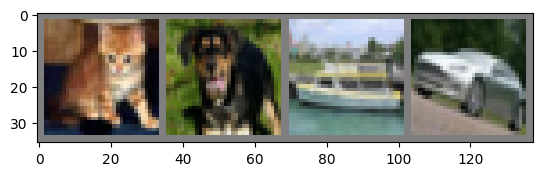

cat   dog   ship  car  


In [6]:
#let's see some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Architecture of CNN

In [158]:
#implement Conv Net
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)  #(RGB=3 classes, output, kernel=5-> 5x5 )
        self.pool = nn.MaxPool2d(2,2) #(kernel =2, stride=2) 
        self.conv2 = nn.Conv2d(6,16,5) 
        self.fc1 = nn.Linear(16*5*5, 128) # (input_features=16*5*5,output_features=120 (arbitrary))
        self.drop1 = nn.Dropout(p=0.2)  #regularization for overfitting for dense NN
        self.drop2 = nn.Dropout2d(p=0.2)  # " "  " " Conv
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 10) # (in_features = n,  output =10) there are 10 classes so 10 outputs needed
        #this is for the network graph connecting  all
                                                                  
    def forward(self,x):  #here we connect all computational graph
        x=self.pool(F.relu(self.conv1(x)))
        #x=self.drop2(x)
        x=self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch or #x=x.view(-1, 16*5*5)         
        x=F.relu(self.fc1(x))
        #x=self.drop1(x) #drop doesn't seem to be efficient this time 
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        x=self.fc4(x)
        return x
model=ConvNet().to(device)    

### Time to training the CNN 

In [159]:
Err_func = nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr=l_rate, weight_decay=0.0001) #you can add this when using SGD (momentum=0.9)
                                                                  
n_tot_steps= len(train_loader) #=n because of the batch_size
t1_time= perf_counter()
for epoch in range(n_epochs): #-- training --
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        
        images=images.to(device)
        labels=labels.to(device)
        
        #forward pass
        outputs = model(images)
        loss = Err_func(outputs, labels)
        
        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 200 == 0 or (i+1 == n_tot_steps):                              #n_tot_steps=12,500
            print(f'Epoch [{epoch+1}/{n_epochs}], | Step [{i+1}/{n_tot_steps}] | Loss {loss.item():.4f}')
print('Finished Training')
PATH = './cnn.pth' #saving the model 
torch.save(model.state_dict(), PATH)
t2_time= perf_counter()
print(f"Time of Network training(s): {t2_time-t1_time}")


Epoch [1/14], | Step [200/782] | Loss 1.9347
Epoch [1/14], | Step [400/782] | Loss 1.6349
Epoch [1/14], | Step [600/782] | Loss 1.6331
Epoch [1/14], | Step [782/782] | Loss 1.4658
Epoch [2/14], | Step [200/782] | Loss 1.5717
Epoch [2/14], | Step [400/782] | Loss 1.4201
Epoch [2/14], | Step [600/782] | Loss 1.4310
Epoch [2/14], | Step [782/782] | Loss 1.2826
Epoch [3/14], | Step [200/782] | Loss 1.4082
Epoch [3/14], | Step [400/782] | Loss 1.1856
Epoch [3/14], | Step [600/782] | Loss 1.2845
Epoch [3/14], | Step [782/782] | Loss 0.9978
Epoch [4/14], | Step [200/782] | Loss 1.3540
Epoch [4/14], | Step [400/782] | Loss 1.1450
Epoch [4/14], | Step [600/782] | Loss 1.3647
Epoch [4/14], | Step [782/782] | Loss 0.9951
Epoch [5/14], | Step [200/782] | Loss 1.1694
Epoch [5/14], | Step [400/782] | Loss 1.2416
Epoch [5/14], | Step [600/782] | Loss 0.9689
Epoch [5/14], | Step [782/782] | Loss 1.1150
Epoch [6/14], | Step [200/782] | Loss 1.3757
Epoch [6/14], | Step [400/782] | Loss 1.2386
Epoch [6/1

###
### Evaluate the overall model 

In [161]:
model.eval()
#counting by class (dictionaries with name of class as key)
correct_pred = {c: 0 for c in classes}
total_pred   = {c: 0 for c in classes}
total_correct=0
total_samples=0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        #max return(value,index) 
        _, predicted =torch.max(outputs, 1) #dim=1 search max in columns(classes) of each row(image),
              # returns (values, indices), so "predicted" stores [index] of max score probability
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0) 
        #for class
        for label, prediction in zip(labels, predicted):
            li = int(label.item())
            pi = int(prediction.item())
            cname = classes[li]
            total_pred[cname] +=1 #count sample in the class
            if li == pi:
                correct_pred[cname]+=1
        
acc_tot= 100.0*total_correct/total_samples
print(f'Accuracy of the Network: {acc_tot:.1f}%')
    
for cname in classes:
    if total_pred[cname] > 0:
        acc_c = 100.0 * correct_pred[cname] / total_pred[cname]
        print(f'Accuracy for class: {cname:5s} is {acc_c:.2f}%')

Accuracy of the Network: 63.6%
Accuracy for class: plane is 63.90%
Accuracy for class: car   is 74.40%
Accuracy for class: bird  is 46.60%
Accuracy for class: cat   is 39.90%
Accuracy for class: deer  is 60.20%
Accuracy for class: dog   is 57.30%
Accuracy for class: frog  is 69.80%
Accuracy for class: horse is 76.20%
Accuracy for class: ship  is 76.20%
Accuracy for class: truck is 71.30%


### If you saved the model load it in the following way. Some steps you should know:
1) run everything except training.
2) Use the same path or the path in which you saved it. 
3) Use same class name.
4) Once you check the summary model, evaluate as usual.

In [162]:
# you need to use the same class name ConvNet(nn.Module):
model = ConvNet()

#load weights 
PATH = './cnn.pth' #same path used above
model.load_state_dict(torch.load(PATH)) 

#eval for deactivating any regularization or batchnorm
model.eval()


ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (drop2): Dropout2d(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)

###
Some random predictions

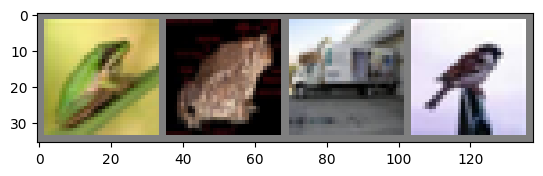

GroundTruth: frog  frog  truck bird 


In [152]:
#let's make some predictions randomly
import random
# dataiter= iter(test_loader)
# images, labels= next(dataiter) #returns all the values of iterator, example [1,2,3] it will print -> 1, 2, 3 finally StopIteration
indices = random.sample(range(len(test_datset)), 4)
# obtain labels and images
images = [test_datset[i][0] for i in indices]
labels = [test_datset[i][1] for i in indices] #test_datset -> list of [image, label]

#print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

####

Now some graphics

              precision    recall  f1-score   support

       plane       0.64      0.72      0.68      1000
         car       0.75      0.77      0.76      1000
        bird       0.52      0.57      0.54      1000
         cat       0.48      0.41      0.44      1000
        deer       0.62      0.53      0.57      1000
         dog       0.55      0.52      0.53      1000
        frog       0.74      0.69      0.71      1000
       horse       0.69      0.71      0.70      1000
        ship       0.68      0.82      0.74      1000
       truck       0.73      0.69      0.71      1000

    accuracy                           0.64     10000
   macro avg       0.64      0.64      0.64     10000
weighted avg       0.64      0.64      0.64     10000



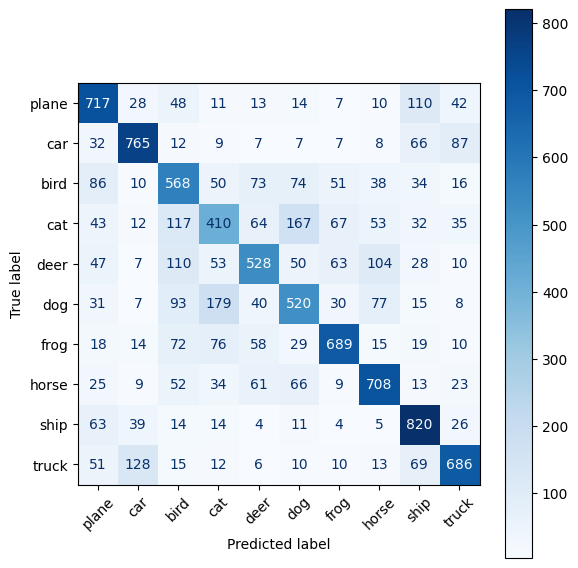

In [153]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        preds= logits.argmax(dim=1)
        y_true.extend(labels.cpu().numpy()) #extend: add elements of array 1D to the list → flat list.
        y_pred.extend(preds.cpu().numpy())

# matriz (clases 0..C-1)
C = len(classes)  # p. ej., 10 en CIFAR-10
cm = confusion_matrix(y_true, y_pred, labels=list(range(C)))

print(classification_report(y_true, y_pred, target_names=classes))

# gráfico
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", colorbar=True)
plt.tight_layout(); plt.show()

### We were able to improve an accuracy from 54% to 64% making adjustments of epochs, Learning rate, weight decay, implementing different units and more layers as well as Adam optimizer instead of SGD